# Toward patch-free:
## Training

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
#import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/BigPatch/"  
PATCH_SIZE=224  # 224 matches VGG
PATCH_SIZE=256
# PATCH_SIZE=512    # dies
# PATCH_SIZE=1024   # dies
# PATCH_SIZE=2048   # kernel death at start of training
DIR_MODELS = "/home/jrm/Martinez/models/"
FILE_MODEL = "PatchFree_002" 
filepath=DIR_MODELS+FILE_MODEL
print("Will overwrite model at "+filepath)
BATCH_SIZE = 32
IMG_SIZE = (PATCH_SIZE,PATCH_SIZE)

Will overwrite model at /home/jrm/Martinez/models/PatchFree_002


In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 12903 files belonging to 2 classes.
Found 3225 files belonging to 2 classes.


In [4]:
# Normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1.0/255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))

In [5]:
#iterator = valid_dataset.take(5)
#for x in iterator:
#    print(x[0].shape)
#    print(x[1])

In [6]:
ACTIVATION="tanh"
NUM_CLASSES = 2
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    #kl.RandomFlip(),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(16,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])


In [7]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=5
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/5
404/404 [==============================] - 59s 140ms/step - loss: 0.5505 - accuracy: 0.7820 - val_loss: 0.5208 - val_accuracy: 0.7857
Epoch 2/5
404/404 [==============================] - 56s 138ms/step - loss: 0.5293 - accuracy: 0.7856 - val_loss: 0.5227 - val_accuracy: 0.7857
Epoch 3/5
404/404 [==============================] - 56s 138ms/step - loss: 0.5275 - accuracy: 0.7857 - val_loss: 0.5195 - val_accuracy: 0.7857
Epoch 4/5
404/404 [==============================] - 55s 137ms/step - loss: 0.5220 - accuracy: 0.7855 - val_loss: 0.5194 - val_accuracy: 0.7857
Epoch 5/5
404/404 [==============================] - 55s 137ms/step - loss: 0.5212 - accuracy: 0.7857 - val_loss: 0.5198 - val_accuracy: 0.7857
Elapsed time: 282.4208490848541


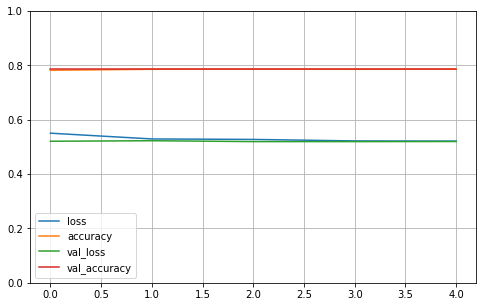

In [8]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

In [9]:
# cnn.save(filepath)

## Dies before epoch 1 with with patch size 2048

## Dies during epoch 1 with patch size 1024

In [10]:
2022-04-05 14:24:44.298579: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (268435456): 	Total Chunks: 4, Chunks in use: 1. 9.00GiB allocated for chunks. 384.00MiB in use in bin. 384.00MiB client-requested in use in bin.
2022-04-05 14:24:44.298896: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] Bin for 16.00GiB was 256.00MiB, Chunk State: 
2022-04-05 14:24:44.299127: I tensorflow/core/common_runtime/bfc_allocator.cc:1039]   Size: 256.00MiB | Requested Size: 128.00MiB | in_use: 0 | bin_num: 20, prev:   Size: 576.0KiB | Requested Size: 576.0KiB | in_use: 1 | bin_num: -1, next:   Size: 128.00MiB | Requested Size: 128.00MiB | in_use: 1 | bin_num: -1
2022-04-05 14:24:44.299134: I tensorflow/core/common_runtime/bfc_allocator.cc:1039]   Size: 384.00MiB | Requested Size: 384.00MiB | in_use: 0 | bin_num: 20, prev:   Size: 128.00MiB | Requested Size: 128.00MiB | in_use: 1 | bin_num: -1, next:   Size: 384.00MiB | Requested Size: 384.00MiB | in_use: 1 | bin_num: -1
2022-04-05 14:24:44.299138: I tensorflow/core/common_runtime/bfc_allocator.cc:1039]   Size: 8.00GiB | Requested Size: 0B | in_use: 0 | bin_num: 20, prev:   Size: 384.00MiB | Requested Size: 384.00MiB | in_use: 1 | bin_num: -1
2022-04-05 14:24:44.299140: I tensorflow/core/common_runtime/bfc_allocator.cc:1046] Next region of size 9799794688
2022-04-05 14:24:44.299948: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f3dce000000 of size 1280 next 1
...
2022-04-05 14:24:44.300123: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] Free  at 7f3de624b500 of size 402653184 next 61
2022-04-05 14:24:44.300125: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7f3dfe24b500 of size 402653184 next 65
2022-04-05 14:24:44.300128: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] Free  at 7f3e1624b500 of size 8589429504 next 18446744073709551615
2022-04-05 14:24:44.300131: I tensorflow/core/common_runtime/bfc_allocator.cc:1071]      Summary of in-use Chunks by size: 
2022-04-05 14:24:44.300136: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 48 Chunks of size 256 totalling 12.0KiB
2022-04-05 14:24:44.300139: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 3 Chunks of size 512 totalling 1.5KiB
2022-04-05 14:24:44.300142: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 1280 totalling 1.2KiB
2022-04-05 14:24:44.300145: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 2048 totalling 2.0KiB
2022-04-05 14:24:44.300148: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 13824 totalling 13.5KiB
2022-04-05 14:24:44.300152: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 147456 totalling 144.0KiB
2022-04-05 14:24:44.300155: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 294912 totalling 288.0KiB
2022-04-05 14:24:44.300158: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 2 Chunks of size 589824 totalling 1.12MiB
2022-04-05 14:24:44.300161: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 134217728 totalling 128.00MiB
2022-04-05 14:24:44.300164: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 402653184 totalling 384.00MiB
2022-04-05 14:24:44.300167: I tensorflow/core/common_runtime/bfc_allocator.cc:1078] Sum Total of in-use chunks: 513.58MiB
2022-04-05 14:24:44.300170: I tensorflow/core/common_runtime/bfc_allocator.cc:1080] total_region_allocated_bytes_: 9799794688 memory_limit_: 9799794688 available bytes: 0 curr_region_allocation_bytes_: 19599589376
2022-04-05 14:24:44.300871: I tensorflow/core/common_runtime/bfc_allocator.cc:1086] Stats: 
Limit:                      9799794688
InUse:                       538523904
MaxInUse:                    941177856
NumAllocs:                          97
MaxAllocSize:                402653184
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2022-04-05 14:24:44.301069: W tensorflow/core/common_runtime/bfc_allocator.cc:474] *_***___*****_______________________________________________________________________________________
2022-04-05 14:24:44.308969: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:684 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[32,128,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
[I 14:24:47.950 NotebookApp] KernelRestarter: restarting kernel (1/5), keep random ports
WARNING:root:kernel 6323ff09-60fd-4cea-b718-ccb4eb748d5f restarted


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-10-1dbbef6fc570>, line 1)

In [ ]:
Epoch 1/5

---------------------------------------------------------------------------
ResourceExhaustedError                    Traceback (most recent call last)
<ipython-input-7-6cc733c7d1e1> in <module>
      4 EPOCHS=5
      5 start = time.time()
----> 6 hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
      7 end = time.time()
      8 print("Elapsed time:",end-start)

~/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py in error_handler(*args, **kwargs)
     65     except Exception as e:  # pylint: disable=broad-except
     66       filtered_tb = _process_traceback_frames(e.__traceback__)
---> 67       raise e.with_traceback(filtered_tb) from None
     68     finally:
     69       del filtered_tb

~/.local/lib/python3.8/site-packages/tensorflow/python/eager/execute.py in quick_execute(op_name, num_outputs, inputs, attrs, ctx, name)
     56   try:
     57     ctx.ensure_initialized()
---> 58     tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
     59                                         inputs, attrs, num_outputs)
     60   except core._NotOkStatusException as e:

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,1024,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/conv2d/Conv2D
 (defined at /home/jrm/.local/lib/python3.8/site-packages/keras/layers/convolutional.py:231)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1010]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/conv2d/Conv2D:
In[0] IteratorGetNext (defined at /home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py:866)	
In[1] sequential/conv2d/Conv2D/ReadVariableOp:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 664, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 583, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
>>>     lambda f: self._run_callback(functools.partial(callback, future))
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
>>>     ret = callback()
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
>>>     yield self.process_one()
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 250, in wrapper
>>>     runner = Runner(ctx_run, result, future, yielded)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 741, in __init__
>>>     self.ctx_run(self.run)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
>>>     yielded = self.gen.send(value)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
>>>     yield gen.maybe_future(dispatch(*args))
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
>>>     yield gen.maybe_future(handler(stream, idents, msg))
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 543, in execute_request
>>>     self.do_execute(
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
>>>     yielded = ctx_run(next, result)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 300, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2857, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3062, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3331, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "<ipython-input-7-6cc733c7d1e1>", line 6, in <module>
>>>     hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/home/jrm/.local/lib/python3.8/site-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

pd.

## Dies at PATCH SIZE 512

## Works great at PATCH SIZE 224

In [ ]:
$ smi
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0  On |                  N/A |
| 18%   41C    P5    17W / 250W |  10512MiB / 11264MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1018      G   /usr/lib/xorg/Xorg                 35MiB |
|    0   N/A  N/A      1584      G   /usr/lib/xorg/Xorg                 72MiB |
|    0   N/A  N/A      1709      G   /usr/bin/gnome-shell               25MiB |
|    0   N/A  N/A      2209      G   /usr/lib/firefox/firefox          147MiB |
|    0   N/A  N/A      2668      G   /usr/lib/firefox/firefox            2MiB |
|    0   N/A  N/A      6570      G   /usr/lib/firefox/firefox            2MiB |
|    0   N/A  N/A      6971      C   /usr/bin/python3                10209MiB |
+-----------------------------------------------------------------------------+


## Works great at PATCH SIZE 256

In [ ]:
$ smi
Tue Apr  5 14:55:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0  On |                  N/A |
| 50%   78C    P2   228W / 250W |  10513MiB / 11264MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|    0   N/A  N/A      1018      G   /usr/lib/xorg/Xorg                 35MiB |
|    0   N/A  N/A      1584      G   /usr/lib/xorg/Xorg                 72MiB |
|    0   N/A  N/A      1709      G   /usr/bin/gnome-shell               25MiB |
|    0   N/A  N/A      2209      G   /usr/lib/firefox/firefox          145MiB |
|    0   N/A  N/A      2668      G   /usr/lib/firefox/firefox            2MiB |
|    0   N/A  N/A      7785      C   /usr/bin/python3                10215MiB |
+-----------------------------------------------------------------------------+
